Detected text: 225
Adjusted Bounding Box (Original Image): Top-left (31, 15), Bottom-right (120, 41)
Found on loop with cropped height 51
Rows cropped: 0
Updated image saved to: D:/FlagDetectionDatasets/ExportedDatasetsReduced/Augmentation/FlagsWithYearOCR/ocr_frame_000140_flag_crop_2.PNG


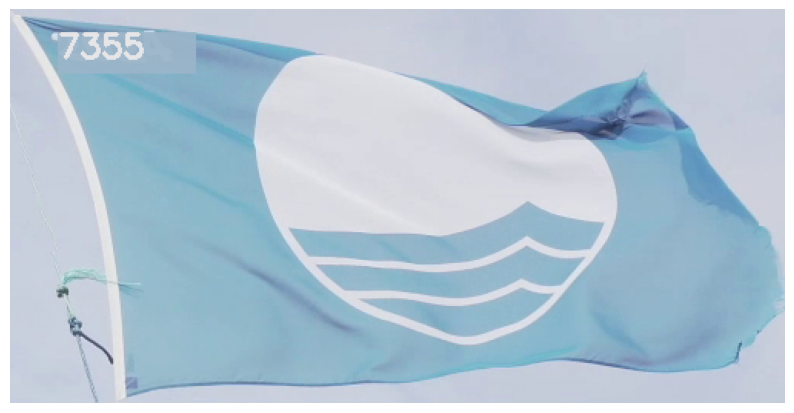

In [41]:
# Listing: A_Aug_OCR_and_replace_Year_Flag_Text_Approach2.jpynb 
# Methodology to identify and replace text on an image (a cropped flag) using Tesseract OCR and OpenCV. 
# Process an input image (intended for a flag) to: 
#   - Locate and identify text 
#   - Define an overlay region around the detected text
#   - Replace detected text with text (e.g., "2026") on a background overlay.
#   - Blend the overlay with the surrounding image area.
#   - Save and display the modified image.
#   - Allow for adjustments for individual images to account for variability in

# locations of detected characters
# Take an input of a cropped flag - initial crop it (5th high/3rd wide) - search for text - overlay text on new overlay -
# Progressively crop the image by 1 row until text is / is not found ...
#  Initial Crop it to 1/5 of height and  1/3 width to localise to the area where the text is on the top left - for flags with text facing correctly 
#  Use Tesseract OCR to search for text - optimise for digits -  
#   If text is found 
#    Get the bounding box of the last character and convert OpenCV format -inverting ys
#    Define an overlay area - 
#    Apply nudge vaues that are user defined and specific to the image -
#     -this is to account for the variability in how the text position is extracted by Tesseract 
#     -The characters are not aligned etc and the challenge of detecting text on an outdoor suspended fabric flag in constant motion and not laid flat  
#   Sample colour from the bottom right of the ovrlay area 
#   Put text on the overlay etc. 
#   Apply overlay blending to blend the overlay into the area on which it is placed 
# 
# If text is not found, progressively crop 1 row from the bottom and repeat until text is or is not found ...
# This approach 2 uses the bounding box of the last character found during OCR detection should help align the overlay and replacement
# text more consistently, as it avoids variability caused by misaligned or distorted individual character positions.
# base the overlay patch and text alignment on the last detected character’s bounding box. 

import cv2
import pytesseract
import numpy as np
from matplotlib import pyplot as plt
import os
import random 

# Load the image
#filename = "croppedflag.png"
#image_path_base=r"D:/FlagDetectionDatasets/a_pSDS/new"
# Nudge values 
#overlay_left_nudge = - 40   # Nudge / Expand overlay to the left
#overlay_top_nudge = - 4     # Pad overlay top 
#overlay_right_nudge = -  2  # Expand/Contract right edge  
#overlay_bottom_nudge =  5   # Slightly pad overlay to the bottom so that it covers text

# Load the image
#filename = "croppedflag.png"
#image_path_base=r"D:/FlagDetectionDatasets/a_pSDS/new"
# Nudge values to expand or contract the coordinates of detected text
overlay_left_nudge =   -56
overlay_top_nudge =    1   
overlay_right_nudge =  15  
overlay_bottom_nudge = 10 

#filename ="frame_000690_flag_crop_2.jpg"
#image_path_base=r"D:/FlagDetectionDatasets/ExportedDatasetsReduced/Augmentation/FlagsWithYearOCR/Cropped_BlueFlags"
#filename = "croppedflag.png"
#filename = "frame_000000_flag_crop_2.PNG"  # overlay_left_nudge =   22 overlay_top_nudge =    9  # Pad upwards / Smaill up overlay_right_nudge =  -22overlay_bottom_nudge = 5 
#filename  = "frame_000005_flag_crop.PNG" # nO TEXT DETECTED 
#filename = "frame_000005_flag_crop.PNG" #' non detected 
#filename = "frame_000020_flag_crop.PNG"
#filename = "frame_000025_flag_crop.PNG" # Good candidate overlay_left_nudge =   22overlay_top_nudge =    12  # Pad upwards overlay_right_nudge =  -22 overlay_bottom_nudge = 5 
#filename = "frame_000035_flag_crop.PNG"
#filename = "frame_000040_flag_crop.PNG"
#filename = "frame_000045_flag_crop.PNG"
#filename = "frame_000050_flag_crop.PNG" 0
#filename = "frame_000035_flag_crop.PNG"   .Not good candiate 
#filename = "frame_000055_flag_crop_2.PNG" #/ no file 
#filename = "frame_000090_flag_crop_2.PNG"
#filename = "frame_000100_flag_crop_2.PNG"
filename = "frame_000140_flag_crop_2.PNG"

#image_path_base="D:/FlagDetectionDatasetsExportedDatasetsReduced/Augmentation/FlagsWithYearOCR/Cropped"
image_path_base=r'D:/FlagDetectionDatasets/ExportedDatasetsReduced/Augmentation/FlagsWithYearOCR_old_2/Cropped'
#image_path_base="D:/FlagDetectionDatasets/ExportedDatasetsReduced/Augmentation/FlagsWithYearOCR/Cropped"
#image_path_base=r"D:/FlagDetectionDatasets/a_pSDS/new"
# Nudge values 
#overlay_left_nudge = - 40   # Nudge / Expand overlay to the left
#overlay_top_nudge = - 4     # Pad overlay top 
#overlay_right_nudge = -  2  # Expand/Contract right edge  
#overlay_bottom_nudge =  5   # Slightly pad overlay to the bottom so that it covers text

# Load the image
#filename = "croppedflag.png"
#image_path_base=r"D:/FlagDetectionDatasets/a_pSDS/new"
# Nudge values to expand or contract the coordinates of detected text
#overlay_left_nudge =   22
#overlay_top_nudge =    9  # Pad upwards / Smaill up 
#overlay_right_nudge =  -22
#overlay_bottom_nudge = 5 

# Nudge values 
#overlay_left_nudge = 30   # Nudge / Expand overlay to the left
#overlay_top_nudge =   14  # Shift overlay top 
#overlay_right_nudge =  - overlay_left_nudge + 10 # Expand/Contract right edge  #
#overlay_bottom_nudge =  5   # Slightly pad overlay to the bottom so that it covers text

image_path = os.path.join(image_path_base, filename)
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Image not found at path: {image_path}")
image_ocr = image.copy()

# Constants and Parameters
# replacement_text = "2026"
# Generate a string of random digits (e.g., 4 digits)
replacement_text = ''.join(random.choices('0123456789', k=4)) # Will be able to get text_size for Open CV 
#print(f"Random replacement text: {replacement_text}")

font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.7
thickness = 2
text_color = (232, 229, 230)  # Off-white (B, G, R)
overlay_alpha = 0.9  # Transparency factor (0: transparent, 1: opaque

# Initial crop dimensions
height, width = image.shape[:2]
cropped_height = height // 5
cropped_width = width // 4

# Variables for OCR and positioning
text_found = False
updated_image = None
text_size = cv2.getTextSize(replacement_text, font, font_scale, thickness)[0]
text_width, text_height = text_size

def draw_debug_box(img, x1, y1, x2, y2, color=(0, 0, 255), label="Box"):
    """Draw a debug bounding box with a label."""
    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
    cv2.putText(img, label, (x1, y1 - 10), font, 0.5, color, 1)

cropped_rows = 0

while cropped_height > 0:
    cropped_img = image[:cropped_height, :cropped_width]
    gray = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)

    # Threshold and blur
    _, thresh = cv2.threshold(gray, 200, 180, cv2.THRESH_BINARY_INV)
    blurred = cv2.GaussianBlur(thresh, (5, 5), 0)

    # Perform OCR
    custom_config = r'--oem 3 --psm 6 -c tessedit_char_whitelist=0123456789'
    #
    text = pytesseract.image_to_string(blurred, config=custom_config).strip()

    if text:
        text_found = True
        print(f"Detected text: {text}")

        # Bounding box calculations for the last detected character
        boxes = pytesseract.image_to_boxes(blurred, config=custom_config)
        h, w = blurred.shape

        # Use the last character bounding box
        last_box = boxes.splitlines()[-1].split()
        x1, y1, x2, y2 = (
            int(last_box[1]),
            h - int(last_box[2]),
            int(last_box[3]),
            h - int(last_box[4]),
        )

        # Visualize bounding box in cropped image
        draw_debug_box(cropped_img, x1, y2, x2, y1, (255, 0, 0), "Detected Text")

        # Adjust coordinates for the original image and apply image specific nudge values 
        overlay_left = max(0, x1) + overlay_left_nudge  
        overlay_top =  max(0, y2) + overlay_top_nudge    
        overlay_right = min(width, x2) + overlay_right_nudge  
        overlay_bottom = max(0, y1) + overlay_bottom_nudge
        #overlay_bottom = (overlay_top + text_height  + overlay_bottom_nudge)

        overlay_left = max(0, x1 + overlay_left_nudge)  
        overlay_top = max(0, y2 + overlay_top_nudge)    
        overlay_right = min(width, x2  + overlay_right_nudge ) 
        overlay_bottom = (overlay_top + text_height  + overlay_bottom_nudge)
          
        # Debugging: Print adjusted coordinates
        print(f"Adjusted Bounding Box (Original Image): Top-left ({overlay_left}, {overlay_top}), "
            f"Bottom-right ({overlay_right}, {overlay_bottom})")

        # Sample the background color from a region around the bounding box
        sample_region = image_ocr[max(0, overlay_top - 2):min(height, overlay_bottom + 2),
                                      max(0, overlay_left - 2):min(width, overlay_right + 2)]
        if sample_region.size > 0:
            background_color = np.mean(sample_region, axis=(0, 1)).astype(int).tolist()
        else:
            background_color = (0, 0, 0)  # Default to black if sampling fails
        
        # Create an overlay image and draw the background
        # Did expermiment with a featherd mask at this point but removed 
        overlay_ocr = image_ocr.copy()
        cv2.rectangle(overlay_ocr,(overlay_left, overlay_top),(overlay_right, overlay_bottom),background_color,-1)

        # Blend the overlay with the original image
        cv2.addWeighted(overlay_ocr, overlay_alpha, image_ocr, 1 - overlay_alpha, 0, image_ocr)

        # Align text within the overlay
        text_x = overlay_left  # Align text left
        text_y = overlay_top + text_height  # Center text vertically in the overlay

        # Place replacement text
        cv2.putText(image_ocr, replacement_text, (text_x, text_y), font, font_scale, text_color, thickness)

        # Save the updated image for final display
        updated_image = image_ocr.copy()
        print(f"Found on loop with cropped height {cropped_height}")
        break  # Stop cropping after finding text

    # Reduce crop height and retry
    cropped_height -= 1
    cropped_rows +=1
       
    # Save and display the results for debugging
    output_patha = f"D:/FlagDetectionDatasets/ExportedDatasetsReduced/Augmentation/FlagsWithYearOCR" #/ocr_{filename}"
    output_path = os.path.join(output_patha, f"{os.path.splitext(merged_filename)[0]}{replacement_text}.PNG")
   
# Process the image until text is found or crop height is zero
print(f"Rows cropped: {cropped_rows}")

if updated_image is not None:
    cv2.imwrite(output_path, updated_image)
    print(f"Updated image saved to: {output_path}")
        
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(updated_image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()
else:
    print("No text detected; no updated image available.")